In [18]:
# allow imports from local "src" directory
import sys
sys.path.append('..')
from src.acq_funcs import EI, PI, cust_acq, thompson
import numpy as np
import math

import pandas as pd
import torch
import gpytorch
import botorch
from botorch.models.gpytorch import GPyTorchModel

from matplotlib import pyplot as plt
from matplotlib import cm
import plotly.express as px

import wandb
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(gpytorch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.7.0


# Data import and preparation

In [19]:
# Load data
fe_data = pd.read_csv('../data/KHM005_KHM006_quartz_HZO_samples.csv', index_col=0)
fe_data_len = len(fe_data['Thickness (nm)'])

# Add duty cycle data
duty_cycle_list = np.array([0.45, 0.55, 0.65])
duty_cycles = np.random.choice(duty_cycle_list, size=fe_data_len)
fe_data['Duty Cycle'] = duty_cycles

# Add num pulses data
num_pulses_list = np.array([15, 25])
num_pulses = np.random.choice(num_pulses_list, size=fe_data_len)
fe_data['Num Pulses'] = num_pulses

# Rearrange columns
cols = list(fe_data.columns.values) 
idx = cols.index("Flash time (msec)")
cols = cols[:idx+1] + cols[-2:] + cols[idx+1:-2]
fe_data = fe_data[cols]

In [20]:
# Write data back to csv
import os  
os.makedirs('../data', exist_ok=True) 
fe_data.to_csv('../data/KHM005_KHM006_quartz_HZO_samples2.csv') 

# Load manipulated data
fe_data = pd.read_csv('../data/KHM005_KHM006_quartz_HZO_samples2.csv', index_col=0)
fe_data.columns

Index(['Thickness (nm)', 'Flash voltage (kV)', 'Flash time (msec)',
       'Duty Cycle', 'Num Pulses', 'Pr (uC/cm2), Pristine state',
       '2Pr (uC/cm2), Pristine state', 'Predicted 2Pr', 'Coersive Voltage',
       'Imprint', 'Endurance', 'Max temperature (degC)'],
      dtype='object')

In [21]:
fe_data.head()

,Thickness (nm),Flash voltage (kV),Flash time (msec),Duty Cycle,Num Pulses,"Pr (uC/cm2), Pristine state","2Pr (uC/cm2), Pristine state",Predicted 2Pr,Coersive Voltage,Imprint,Endurance,Max temperature (degC)
1,10,2.0,2.0,0.55,25,1.39,2.78,NaN,0.49,-0.002,100000000.0,342
2,10,2.0,5.0,0.55,25,3.94,7.88,NaN,0.84,0.122,10000000.0,345
3,10,2.2,1.0,0.45,15,4.69,9.38,NaN,0.74,0.069,10000000.0,361
4,10,2.2,1.5,0.65,25,13.82,27.64,NaN,0.93,0.195,1000000.0,403
5,10,2.2,2.0,0.65,15,13.81,27.62,NaN,0.97,0.144,100000.0,427


In [22]:
# Plot each cross-section
fig = px.scatter_matrix(fe_data, dimensions=["Flash voltage (kV)", "Flash time (msec)", "Duty Cycle", "Num Pulses", "Pr (uC/cm2), Pristine state"])
# fig.update_layout(margin=dict(r=20, l=10, b=10, t=10))
fig.update_layout(height=1000)
fig.show()

In [23]:
def grid_helper(grid_size, num_params, grid_bounds):
    grid = torch.zeros(grid_size, num_params)
    f_grid_diff = lambda i, x, y : float((x[i][1] - x[i][0]) / (y-2))
    for i in range(num_params):
        grid_diff = f_grid_diff(i, grid_bounds, grid_size)
        grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                    grid_bounds[i][1] + grid_diff, grid_size)
    return grid

In [24]:
# Prep training data
from sklearn.preprocessing import StandardScaler
T_scaler = StandardScaler()

# Filter training data 
mask = ~np.isnan(fe_data['Pr (uC/cm2), Pristine state'])
train_x = torch.Tensor(np.array([fe_data['Flash voltage (kV)'][mask].values, 
                       fe_data['Flash time (msec)'][mask].values, 
                       fe_data['Duty Cycle'][mask].values,
                       fe_data['Num Pulses'][mask].values])).T
train_y = torch.Tensor(fe_data['Pr (uC/cm2), Pristine state'][mask].values)

# Define grid between bounds of RTA time, RTA temp
num_params = train_x.size(dim=1)
grid_bounds = [(train_x[:,i].min(), train_x[:,i].max()) for i in range(num_params)]
grid = grid_helper(20, num_params, grid_bounds)

# Set up test_grid for predictions
n = 30
test_grid = grid_helper(n, num_params, grid_bounds)

# Create 4D grid
args = (test_grid[:, i] for i in range(num_params))
test_x = torch.cartesian_prod(*args)
test_x.shape

torch.Size([810000, 4])

In [25]:
def intermediate_plot(f, ax, obs, title):
    im = ax.imshow(obs.mean.view(n, n), aspect='equal',
                extent=[grid_bounds[0][0].item(), grid_bounds[0][1].item(),
                            grid_bounds[1][0].item(), grid_bounds[1][1].item()])
    f.colorbar(im)
    # ax.scatter(train_x[:,0], train_x[:,1], c=train_y)
    ax.set_title(title)

# wandb setup
Run the INIT cell if we wish to just try one configuration; else run the notebook
as is for sweeps.

In [26]:
# ##### INIT ########
# config_defaults = {
#     "epochs": 5000,
#     "kernel": "rbf",
#     "lr": 0.1,
#     "lscale_1": 10,
#     "lscale_2": 10,
#     "lscale_3": 10,
#     "lscale_4": 100,
#     "noise": torch.ones(len(train_x)) * 5.0
# }
# wandb.init(project="fegp runs",config=config_defaults)
# config = wandb.config

In [27]:
###### SWEEPS ########
config = {
  "name" : "ferro_GP",
  "method" : "bayes",
  "metric": {
    "goal": "minimize",
    "name" : "train loss"
  },
  "parameters" : {
    "epochs" : {
        "values" : [5000,6000,7000,8000,9000,10000]
    },
    "lr" : {
        "values": [1e1, 1e0, 1e-1, 1e-2]
    },
    "kernel": {
        "values": ["rbf"]
    },
    "lscale_1": {
        "values": [0.1,0.5,1.0,5.0,10.0]
    },
    "lscale_2": {
        "values": [0.1,0.5,1.0,5.0,10.0]
    },
    "lscale_3": {
        "values": [0.1,0.5,1.0,5.0,10.0]
    },
    "lscale_4": {
        "values": [0.1,0.5,1.0,5.0,10.0]
    },
    "noise": {
        "values": [3.0, 5.0]
    }
  }
}

sweep_id = wandb.sweep(config)

Create sweep with ID: swoc5kag
Sweep URL: https://wandb.ai/valenetjong/uncategorized/sweeps/swoc5kag


# Build GP Classes/Models
A bit of pytorch-esque construction here, but the important parts to take note of are the kernel / mean modules and `noises` array.  

In [28]:
# Switch kernel
def kernel_func(config_kernel):
    if config_kernel == "rbf":
        return gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_params))

In [29]:
# GP model class
class GridGP(gpytorch.models.ExactGP, GPyTorchModel):
    _num_outputs = 1
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(GridGP, self).__init__(train_x, train_y, likelihood)  
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [30]:
# # Init GP model
# config = wandb.config
# kernel = kernel_func(config.kernel) 
# noises = config.noise * torch.ones(len(train_x))
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises)
# model = GridGP(train_x, train_y, likelihood, kernel)

In [31]:
# Init GP model
def make_model(train_x, train_y, config):
    # 0-observation noise case
    # likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # Case for fixed observation noise.  This is set to 5 based on the magnitude of
    # the data, but can be played with.
    kernel = kernel_func(config.kernel)
    noises = config.noise * torch.ones(len(train_x))
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises)
    model = GridGP(train_x, train_y, likelihood, kernel)
    lscale = [config.lscale_1, config.lscale_2, config.lscale_3, config.lscale_4]
    model.covar_module.base_kernel.lengthscale = torch.tensor(lscale)
    return likelihood, model

In [32]:
# # Train and evaluate the model.  (short form)
# from botorch.optim.fit import fit_gpytorch_torch

# # initialize the log-likelihood, and supply it to the GP.  This will be used to 
# # make predictions.  
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
# mll.train()
# # convenience function for fitting gpytorch models
# fit_gpytorch_torch(mll, options={'maxiter':2000, 'lr':10}) 
# mll.eval()

In [33]:
# Training loop (long form, for inspection of results during training)
def train():
    wandb.init(project="fegp runs")
    config = wandb.config
    likelihood, model = make_model(train_x, train_y, config)
    training_iter = config.epochs

    # Place both the model and likelihood in training mode
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)

        # backpropogate error
        wandb.define_metric("train loss", summary="min")
        loss = -mll(output, train_y)
        wandb.log({"train loss": loss.item()})
        loss.backward()

        if i % 100 == 0: 
            print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
                    i+1, training_iter, loss.item(), 
                    model.covar_module.base_kernel.lengthscale.detach().numpy(),
                    model.likelihood.noise.detach().numpy()
                    )) 

                    # # get a quick snapshot of intermediate 
                    # model.eval()
                    # likelihood.eval()
                    # with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    #     obs = likelihood(model(test_x))

                    #     f, ax = plt.subplots(1, 1, figsize=(4,3))
                    #     intermediate_plot(f, ax, obs, f'iter {i+1}/{training_iter}')
                    # model.train()
                    # likelihood.train()
        optimizer.step()
        
        # Save trained model
        # torch.save(model.state_dict(), 'models/my_gp_with_nn_model.pth')

In [34]:
%env "WANDB_NOTEBOOK_NAME" "ferro_GPS"
wandb.agent(sweep_id, function=train)

env: "WANDB_NOTEBOOK_NAME"="ferro_GPS"


wandb: Agent Starting Run: prdfmbpb with config:
wandb: 	epochs: 8000
wandb: 	kernel: rbf
wandb: 	lr: 0.1
wandb: 	lscale_1: 10
wandb: 	lscale_2: 0.1
wandb: 	lscale_3: 0.5
wandb: 	lscale_4: 1
wandb: 	noise: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Iter 1/8000 - Loss: 23.659  lengthscale1: [[10.   0.1  0.5  1. ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 101/8000 - Loss: 5.133  lengthscale1: [[0.39051932 2.7004526  2.1693068  3.705029  ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 201/8000 - Loss: 4.222  lengthscale1: [[ 0.39648885  2.500643    1.7165682  12.714659  ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 301/8000 - Loss: 3.667  lengthscale1: [[ 0.32240134  2.3760781   0.07306687 14.5714    ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 401/8000 - Loss: 3.374  lengthscale1: [[ 0.26540822  2.9838977   0.06560574 16.633297  ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 501/8000 - Loss: 3.275  lengthscale1: [[ 0.24270286  2.8804586   0.06553904 17.754234  ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 601/8000 - Los

train loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: ckwuqlq6 with config:
wandb: 	epochs: 5000
wandb: 	kernel: rbf
wandb: 	lr: 0.01
wandb: 	lscale_1: 1
wandb: 	lscale_2: 0.1
wandb: 	lscale_3: 1
wandb: 	lscale_4: 5
wandb: 	noise: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Iter 1/5000 - Loss: 23.250  lengthscale1: [[1.  0.1 1.  5. ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 101/5000 - Loss: 14.177  lengthscale1: [[1.528707  0.3794854 1.5745707 5.9948697]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 201/5000 - Loss: 9.978  lengthscale1: [[1.4817872 0.7595186 1.9505284 6.7847257]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 301/5000 - Loss: 8.297  lengthscale1: [[0.87212294 0.9929054  2.2064488  7.35562   ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 401/5000 - Loss: 7.264  lengthscale1: [[0.6788375 1.1948504 2.3943481 7.842138 ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 501/5000 - Loss: 6.534  lengthscale1: [[0.6270915 1.4445956 2.5368695 8.244667 ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 601/5000 - Loss: 5.950  lengthscale1: [[0.5908241

train loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: c8o77yp1 with config:
wandb: 	epochs: 5000
wandb: 	kernel: rbf
wandb: 	lr: 10
wandb: 	lscale_1: 0.1
wandb: 	lscale_2: 10
wandb: 	lscale_3: 1
wandb: 	lscale_4: 0.5
wandb: 	noise: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Iter 1/5000 - Loss: 21.891  lengthscale1: [[ 0.1 10.   1.   0.5]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 101/5000 - Loss: 6.107  lengthscale1: [[5.6382153e+01 7.5578988e-10 6.0111897e+01 8.7665118e-14]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 201/5000 - Loss: 6.105  lengthscale1: [[5.4875465e+01 7.5578988e-10 5.9539719e+01 8.7665118e-14]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 301/5000 - Loss: 6.103  lengthscale1: [[5.2736393e+01 7.5578988e-10 5.8774498e+01 8.7665118e-14]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 401/5000 - Loss: 6.101  lengthscale1: [[4.9876209e+01 7.5578988e-10 5.7844353e+01 8.7665118e-14]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Iter 501/5000 - Loss: 6.098  lengthscale1: [[4.6046356e+01 7.5578988e-10 5.6765163e+01 8.7665118e-14]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 

train loss,▇█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Run c8o77yp1 errored: NanError('cholesky_cpu: 441 of 441 elements of the torch.Size([21, 21]) tensor are NaN.')
wandb: ERROR Run c8o77yp1 errored: NanError('cholesky_cpu: 441 of 441 elements of the torch.Size([21, 21]) tensor are NaN.')
wandb: Agent Starting Run: 2646tphv with config:
wandb: 	epochs: 9000
wandb: 	kernel: rbf
wandb: 	lr: 10
wandb: 	lscale_1: 5
wandb: 	lscale_2: 0.5
wandb: 	lscale_3: 0.1
wandb: 	lscale_4: 5
wandb: 	noise: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Iter 1/9000 - Loss: 16.384  lengthscale1: [[5.  0.5 0.1 5. ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 101/9000 - Loss: 4.531  lengthscale1: [[38.899788 55.72497  57.795006 21.056992]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 201/9000 - Loss: 4.520  lengthscale1: [[38.90234  42.95024  57.793274 24.266739]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 301/9000 - Loss: 4.664  lengthscale1: [[ 38.896515  16.483263  57.78662  143.51768 ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 401/9000 - Loss: 4.659  lengthscale1: [[ 38.88588   14.147557  57.776867 143.0879  ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 501/9000 - Loss: 4.652  lengthscale1: [[ 38.872627  14.350512  57.76457  140.55878 ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 601/9000 - Loss: 4.644  lengthscale1: [[ 3

train loss,█▇▇▆▆███▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁


Run 2646tphv errored: NanError('cholesky_cpu: 441 of 441 elements of the torch.Size([21, 21]) tensor are NaN.')
wandb: ERROR Run 2646tphv errored: NanError('cholesky_cpu: 441 of 441 elements of the torch.Size([21, 21]) tensor are NaN.')
wandb: Agent Starting Run: v5jz4g84 with config:
wandb: 	epochs: 5000
wandb: 	kernel: rbf
wandb: 	lr: 10
wandb: 	lscale_1: 0.1
wandb: 	lscale_2: 5
wandb: 	lscale_3: 1
wandb: 	lscale_4: 10
wandb: 	noise: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Iter 1/5000 - Loss: 19.994  lengthscale1: [[ 0.1  5.   1.  10. ]]   noise: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


train loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂


Run v5jz4g84 errored: NanError('cholesky_cpu: 441 of 441 elements of the torch.Size([21, 21]) tensor are NaN.')
wandb: ERROR Run v5jz4g84 errored: NanError('cholesky_cpu: 441 of 441 elements of the torch.Size([21, 21]) tensor are NaN.')
wandb: Agent Starting Run: f710grkp with config:
wandb: 	epochs: 5000
wandb: 	kernel: rbf
wandb: 	lr: 0.1
wandb: 	lscale_1: 0.1
wandb: 	lscale_2: 1
wandb: 	lscale_3: 1
wandb: 	lscale_4: 10
wandb: 	noise: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Iter 1/5000 - Loss: 17.414  lengthscale1: [[ 0.1  1.   1.  10. ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 101/5000 - Loss: 4.139  lengthscale1: [[ 0.5467011  4.4380164  3.7381754 15.044779 ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 201/5000 - Loss: 3.760  lengthscale1: [[ 0.486264   4.1226206  3.4383743 16.938984 ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 301/5000 - Loss: 3.498  lengthscale1: [[ 0.40913862  3.2507417   0.10038917 18.060436  ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 401/5000 - Loss: 3.212  lengthscale1: [[ 0.3070284   3.6549156   0.06694297 19.293747  ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 501/5000 - Loss: 3.139  lengthscale1: [[ 0.2828053   3.5174773   0.06625411 20.048615  ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 601/5000 - Loss: 3

train loss,█▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: zk5vfi4y with config:
wandb: 	epochs: 6000
wandb: 	kernel: rbf
wandb: 	lr: 0.01
wandb: 	lscale_1: 0.1
wandb: 	lscale_2: 10
wandb: 	lscale_3: 0.1
wandb: 	lscale_4: 0.1
wandb: 	noise: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


# Make and plot predictions

In [225]:
# make predictions (whether by long or short form)
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # also use mll from short form 
    obs = likelihood(model(test_x), noise=(torch.ones(len(test_x))*5))
# print(f'train data: {fe_data["2Pr (uC/cm2), Pristine state"][1]}')
# print(f'observed: {obs.mean}')

In [19]:
obs.covariance_matrix.shape

# Make predictions and plot the mean surface

In [1]:
# # non-log scale 3D plot

# pred_labels = obs.mean.view(n, n)
# # plot?...
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Surface(z=pred_labels.numpy().T, x=test_grid[:,0], y=test_grid[:,1], name='GP regression')])
# fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(),y=train_x[:,1].numpy(),  
#                         z=train_y.numpy(), mode='markers', marker={'color':'darkgreen'}, name='training data'))
# fig.update_layout( width=1000, height=800,
#                   legend=dict(orientation="h", yanchor="top", y=1.02, xanchor="left",x=1),
#                    margin=dict(r=20, l=10, b=10, t=10), 
#                     scene=dict(
#                     xaxis_title="Flash voltage (kV)",
#                     yaxis_title="Flash time (msec)",
#                     zaxis_title='Pr (uC/cm^2), Pristine')
#                 )
# camera = dict(
#     up=dict(x=0, y=0, z=1),
#     center=dict(x=0, y=0, z=0),
#     eye=dict(x=-2, y=-2.5, z=1.75)
# )

# fig.update_layout(scene_camera=camera)
# fig.show()

In [ ]:
# # log scale
# pred_labels = obs.mean.view(n, n)
# # plot?...
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Surface(z=pred_labels.numpy().T, x=test_grid[:,0], y=test_grid[:,1], name='GP regression')])
# fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(),y=train_x[:,1].numpy(),  
#                         z=train_y.numpy(), mode='markers', marker={'color':'darkgreen'}, name='trianing data'))
# fig.update_layout( #width=1000, height=800,
#                   legend=dict(orientation="h", yanchor="top", y=1.02, xanchor="left",x=1),
#                    margin=dict(r=20, l=10, b=10, t=10), 
#                     scene=dict(
#                     xaxis_title="RTA temperature (C)",
#                     yaxis_title="RTA time (sec)",
#                     zaxis_title='2Pr (uC/cm2), Pristine')
#                 )
# fig.show()

# Evaluate acquisition functions
This is a bit over-engineered at the moment, as it was built to allow use of the acquisition functions in bayesian optimization loops (botorch functionality).  The below cells should suffice to return the needed results.  

In [1]:
# Evaluate acquisition functions on current predictions (observations)
bounds = [1,1,1,1]

# Probability of Improvement
PI_acq = PI(obs, bounds, train_y)
PI_acq_shape = PI_acq.detach().numpy().reshape(30,30,30,30).T

# Expected Improvement
EI_acq = EI(obs, bounds, train_y)
EI_acq_shape = EI_acq.detach().numpy().reshape(30,30,30,30).T

# Custom Acquisition (something I was playing with)
ca_acq = cust_acq(obs, bounds, train_y)
ca_acq_shape = ca_acq.detach().numpy().reshape(30,30,30,30).T

# Thompson Acquisition function
th_acq = thompson(obs, bounds, train_y)
th_acq_shape = th_acq.detach().numpy().reshape(30,30,30,30).T
# fig = go.Figure(data=[go.Surface(z=acq, x=test_grid[:,0], y=test_grid[:,1])])


ModuleNotFoundError: No module named 'src'

In [ ]:
ei = np.unravel_index(EI_acq_shape.argmax(), EI_acq_shape.shape)
pi = np.unravel_index(PI_acq_shape.argmax(), PI_acq_shape.shape)
ca = np.unravel_index(ca_acq_shape.argmax(), ca_acq_shape.shape)
th = np.unravel_index(th_acq_shape.argmax(), th_acq_shape.shape)

In [ ]:
# Plot the acquisition function results alongside the confidence bound surfaces
pred_var = obs.variance.view(n, n).detach().numpy().T
lower, upper = obs.confidence_region()
upper_surf = upper.detach().numpy().reshape(30,30,30,30).T
lower_surf = lower.detach().numpy().reshape(30,30,30,30).T

ucb = np.unravel_index(upper_surf.argmax(), upper_surf.shape)
max_var = np.unravel_index(pred_var.argmax(), pred_var.shape)
ei = np.unravel_index(EI_acq_shape.argmax(), EI_acq_shape.shape)
pi = np.unravel_index(PI_acq_shape.argmax(), PI_acq_shape.shape)

In [ ]:
# plot?...
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z = upper_surf, x=test_grid[:,0], y=test_grid[:,1], opacity=0.5, showscale=False)])
fig.add_trace(go.Surface(z = lower_surf, x=test_grid[:,0], y=test_grid[:,1], opacity=0.5, showscale=False))
fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(), y=train_x[:,1].numpy(), 
                            z=train_y.numpy(), mode='markers', name='training data', marker={'color':'darkgreen'}))

fig.add_trace(go.Scatter3d(x=test_grid[ucb[1], 0].numpy(), y=test_grid[ucb[0], 1].numpy(), 
                            z=[pred_labels[ucb[0], ucb[1]]], mode='markers', name='max(upper confidence bound)')) 
fig.add_trace(go.Scatter3d(x=test_grid[th[1], 0].numpy(), y=test_grid[th[0],1].numpy(), 
                            z=[pred_labels[th[0], th[1]].detach().numpy()], mode='markers', name='max(thompson)')) 
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[pred_labels[pi[0], pi[1]]], mode='markers', name='max(pi)'))

fig.add_trace(go.Scatter3d(x=test_grid[ei[1], 0].numpy(), y=test_grid[ei[0], 1].numpy(), z=[pred_labels[ei
[0], ei[1]]], mode='markers', name='max(ei)'))

fig.add_trace(go.Scatter3d(x=test_grid[ca[1], 0].numpy(), y=test_grid[ca[0], 1].numpy(), z=[pred_labels[ca[0], ca[1]]], mode='markers', name='max(ca)'))


fig.update_layout( width=800, height=600,
                  margin=dict(r=20, l=10, b=10, t=10),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right",x=1),
                  scene=dict(
                    xaxis_title="Flash voltage (kV)",
                    yaxis_title="Flash time (msec)",
                    zaxis_title='Pr (uC/cm^2), Pristine')
                  )
fig.show()

In [ ]:
# Simply print the locations of the suggested points
print(test_grid[ei[1], 0], test_grid[ei[0], 1])
print(test_grid[pi[1], 0], test_grid[pi[0], 1])
print(test_grid[ca[1], 0], test_grid[ca[0], 1])
print(test_grid[ucb[1], 0], test_grid[ucb[0], 1])
print(test_grid[th[1], 0], test_grid[th[0], 1])
print(test_grid[max_var[1], 0], test_grid[max_var[0], 1])

tensor(415.0862) tensor(114.9384)
tensor(415.0862) tensor(114.9384)
tensor(453.8793) tensor(451.8842)
tensor(402.1552) tensor(451.8842)
tensor(712.5000) tensor(388.7069)
tensor(647.8448) tensor(430.8251)


In [ ]:
print(pred_labels[ei[0], ei[1]])
print(pred_labels[pi[0], pi[1]])
print(pred_labels[ca[0], ca[1]])
print(pred_labels[ucb[0], ucb[1]])
print(pred_labels[th[0], th[1]])
print(pred_labels[max_var[0], max_var[1]])


tensor(36.4777)
tensor(36.4777)
tensor(25.6007)
tensor(23.9889)
tensor(26.0637)
tensor(26.0657)


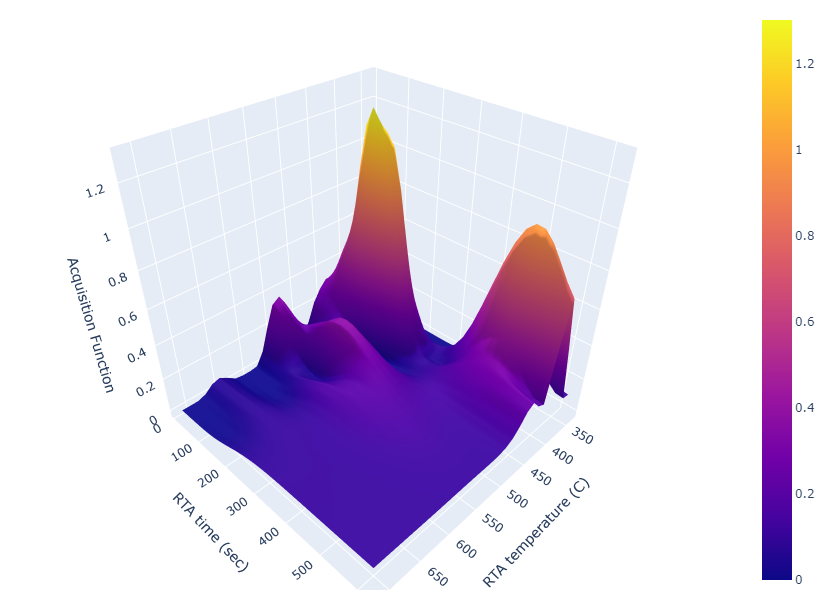

In [ ]:
# look at acq_func manifold
fig = go.Figure(data=[go.Surface(z=EI_acq_shape, x=test_grid[:,0], y=test_grid[:,1])])
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[PI_acq_shape[pi[0], pi[1]]], mode='markers', name='max(pi)'))
fig.update_layout( width=1000, height=600,
                  margin=dict(r=20, l=10, b=10, t=10),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right",x=1),
                  scene=dict(
                    xaxis_title="RTA temperature (C)",
                    yaxis_title="RTA time (sec)",
                    zaxis_title='Acquisition Function')
                  )
fig.show()

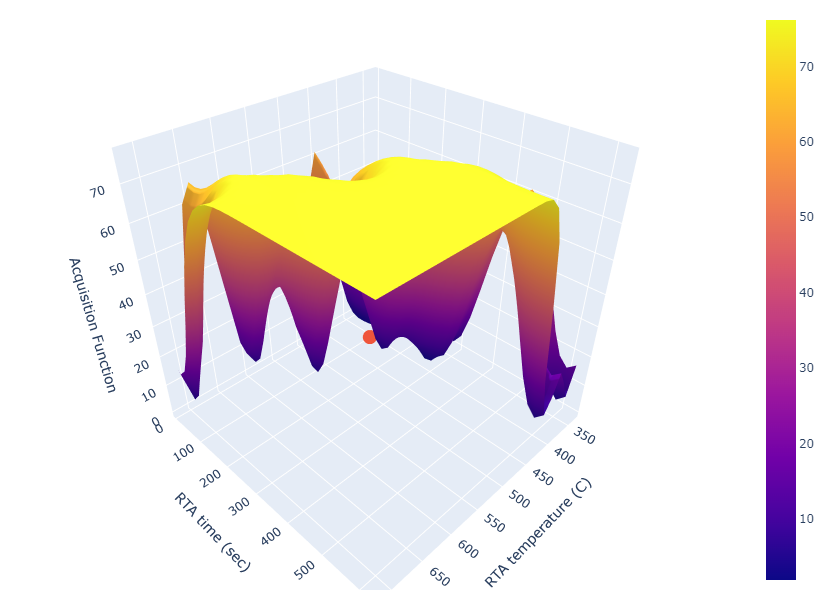

In [ ]:
# look at acq_func manifold
fig = go.Figure(data=[go.Surface(z=pred_var, x=test_grid[:,0], y=test_grid[:,1])])
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[PI_acq_shape[pi[0], pi[1]]], mode='markers', name='max(pi)'))
fig.update_layout( width=1000, height=600,
                  margin=dict(r=20, l=10, b=10, t=10),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right",x=1),
                  scene=dict(
                    xaxis_title="RTA temperature (C)",
                    yaxis_title="RTA time (sec)",
                    zaxis_title='Acquisition Function')
                  )
fig.show()